# Comparing Bandit Agents

This notebook compares the performance of different bandit agents.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from bart_playground.bandit.sim_util import (LinearScenario, LinearOffsetScenario, OffsetScenario, FriedmanScenario)
from compare_agents import (
    compare_agents_across_scenarios, print_summary_results, plot_comparison_results
)

In [2]:
# Create test scenarios
np.random.seed(42)
    
scenarios = {
    "Linear": LinearScenario(P=4, K=3, sigma2=1.0),
    "LinearOffset": LinearOffsetScenario(P=4, K=3, sigma2=1.0),
    "Offset1": OffsetScenario(P=4, K=3, sigma2=1.0),
    "Offset2": OffsetScenario(P=4, K=3, sigma2=0.1),
    "Friedman": FriedmanScenario(P=5, K=3, sigma2=1.0, lambda_val=5)
}

np.random.seed(None)

In [3]:
# Define experiment parameters
n_simulations = 24  # Number of simulations per scenario
n_draws = 600      # Number of draws per simulation

# Run the comparison
results = compare_agents_across_scenarios(
    scenarios=scenarios,
    n_simulations=n_simulations,
    n_draws=n_draws
)


Evaluating Linear scenario...


Simulating: 100%|██████████| 24/24 [23:19<00:00, 58.31s/it]



Evaluating LinearOffset scenario...


Simulating: 100%|██████████| 24/24 [23:01<00:00, 57.55s/it]



Evaluating Offset1 scenario...


Simulating: 100%|██████████| 24/24 [24:56<00:00, 62.37s/it]



Evaluating Offset2 scenario...


Simulating: 100%|██████████| 24/24 [22:47<00:00, 56.99s/it]



Evaluating Friedman scenario...


Simulating: 100%|██████████| 24/24 [23:27<00:00, 58.65s/it]


## Print Summary Results

Let's print a summary of the results for each scenario.

In [4]:
print_summary_results(results)


=== Linear Scenario ===

Final cumulative regrets (mean ± std):
  Random: 6426.47 (±278.53)
  LinearTS: 106.18 (±34.76)
  BCF: 2722.76 (±1525.55)

Average computation times (seconds):
  Random: 0.0102 (±0.0029)
  LinearTS: 0.1324 (±0.0125)
  BCF: 57.4970 (±1.0667)


=== LinearOffset Scenario ===

Final cumulative regrets (mean ± std):
  Random: 628.77 (±21.19)
  LinearTS: 612.93 (±18.71)
  BCF: 384.66 (±170.54)

Average computation times (seconds):
  Random: 0.0094 (±0.0028)
  LinearTS: 0.1322 (±0.0098)
  BCF: 56.7831 (±1.2123)


=== Offset1 Scenario ===

Final cumulative regrets (mean ± std):
  Random: 4515.12 (±118.87)
  LinearTS: 3276.80 (±135.58)
  BCF: 242.62 (±36.88)

Average computation times (seconds):
  Random: 0.0115 (±0.0025)
  LinearTS: 0.1318 (±0.0129)
  BCF: 61.5612 (±18.1077)


=== Offset2 Scenario ===

Final cumulative regrets (mean ± std):
  Random: 5889.76 (±198.71)
  LinearTS: 5503.00 (±182.98)
  BCF: 397.66 (±110.18)

Average computation times (seconds):
  Random: 

## Visualize Results

Finally, let's visualize the cumulative regret for each agent across scenarios.

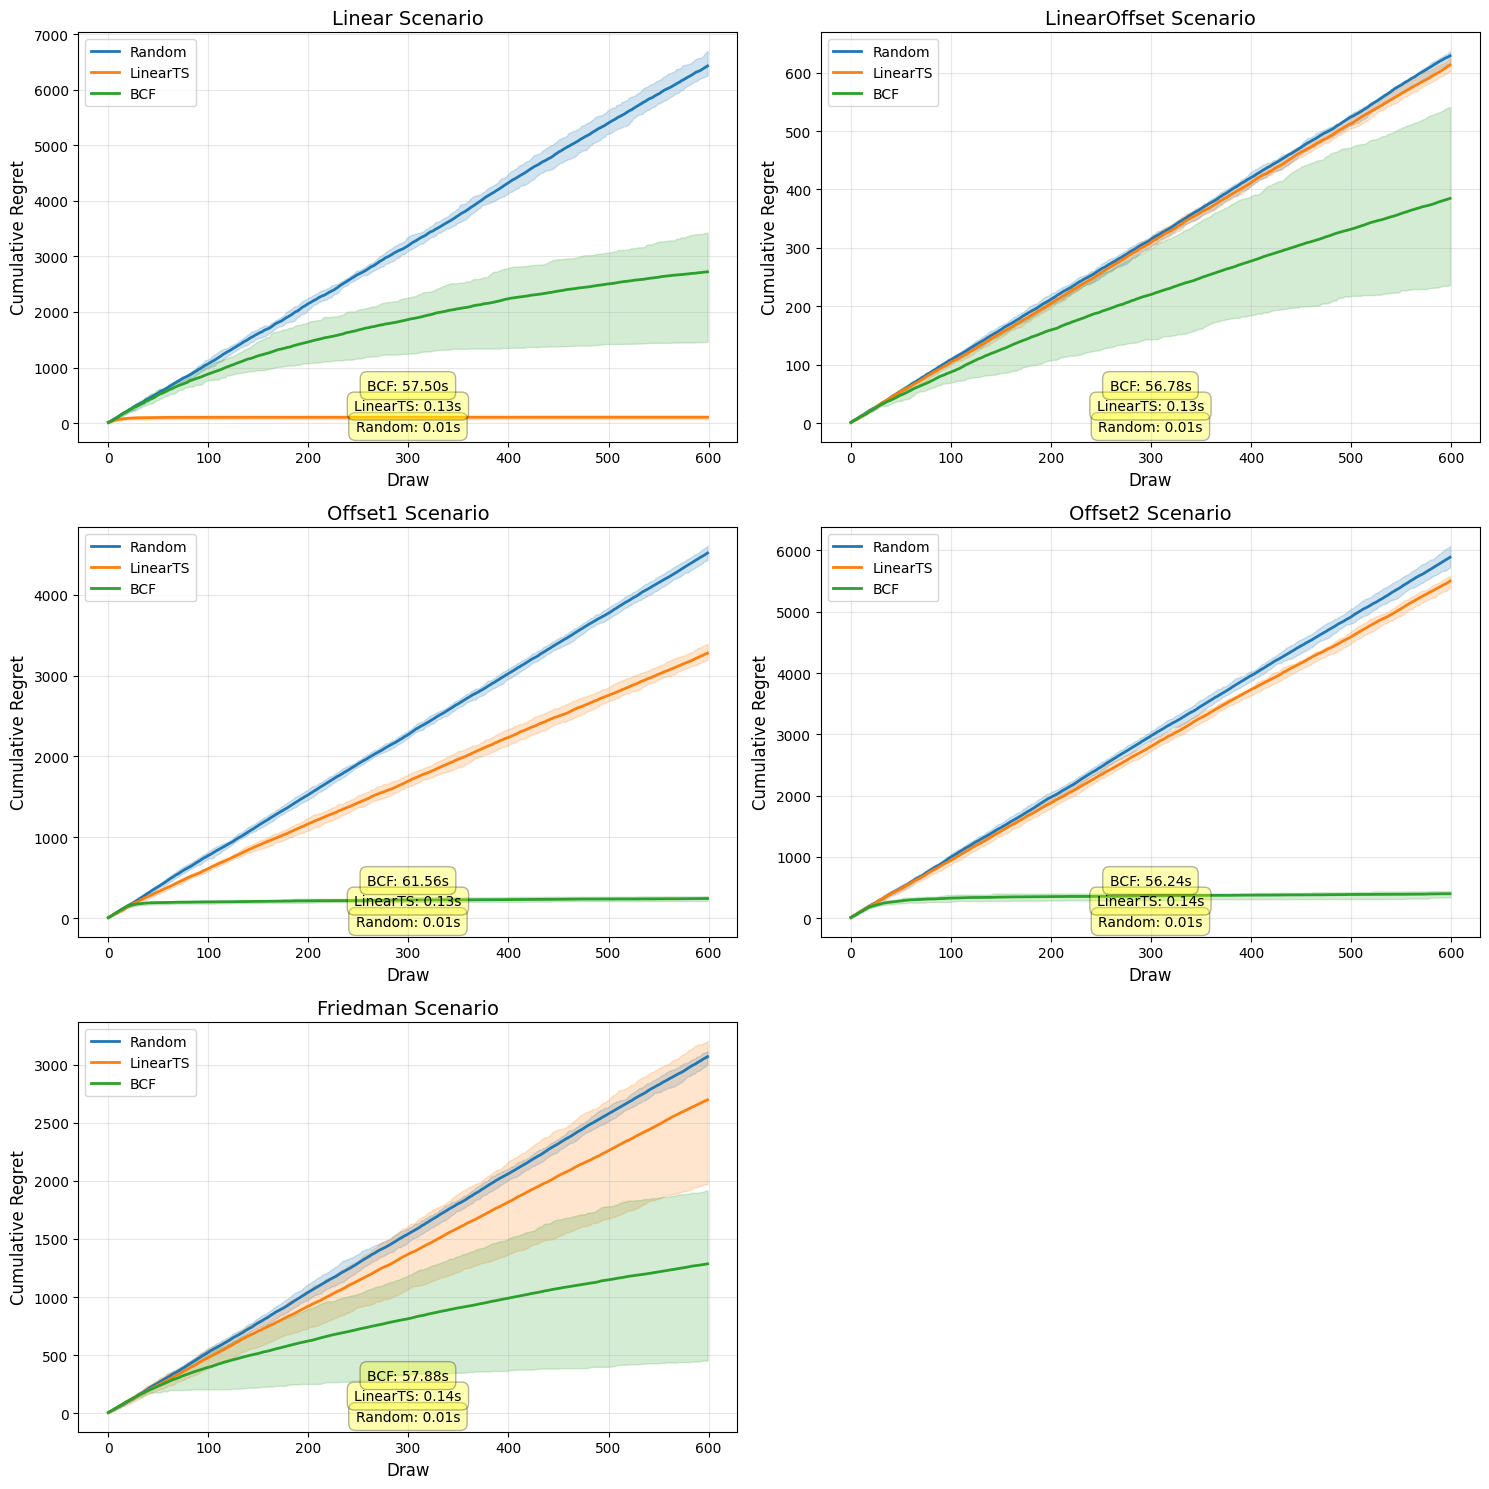

In [5]:
# Create results directory if it doesn't exist
results_dir = "./results/agent_comparison"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Plot results and save to file
plot_comparison_results(
    results=results,
    n_draws=n_draws,
    save_path=f"{results_dir}/agent_comparison_results.png"
)